In [1]:
# %load ../uoicorr_imports.py
%load_ext autoreload
%autoreload 2

import h5py

import numpy as np
import matplotlib.pyplot as plt

import sys, os, pdb

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
	parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
	sys.path.append(p)

# And standard list of subdirectories
if '%s\\pyuoi' % p not in sys.path:
	sys.path.append('%s\\pyuoi' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

if '%s\\uoicorr' % p not in sys.path:
    sys.path.append('%s\\uoicorr' % p)

from postprocess import postprocess_file, postprocess_dir

In [2]:
from utils import block_covariance

### Basic question to be answered: To what extent is there a relationship between the correlation of two variables and the magnitudes assigned by Elastic Net, UoI Elastic Net? What are the magnitudes of the false positives/false negatives of UoI Elastic Net and Elastic Net?

In [3]:
uoil = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\01102019', True)

(120, 16)


In [4]:
# Start with block correlations, and see to what extent coefficient magnitudes are similar
uoien = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\01132019b', True)

(120, 16)


In [5]:
en = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\01142019b', True)

(120, 16)


## Beginning with block size 6, for each sparsity, and for each correlation, find the the indices of false negatives for each repetition and the corresponding correlation (by reconstructing sigma)

In [5]:
d1 = uoien.loc[uoien['block_size'] == 6]

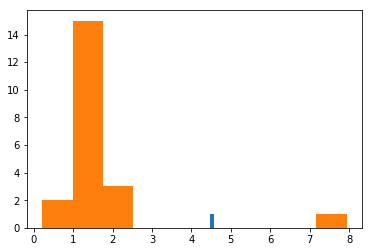

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


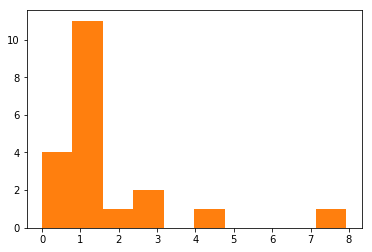

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


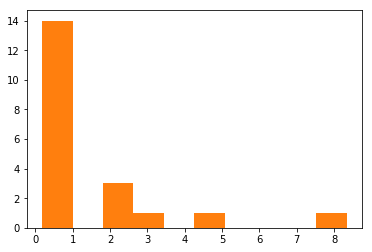

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


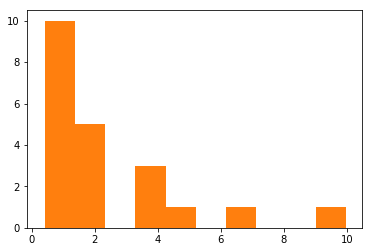

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


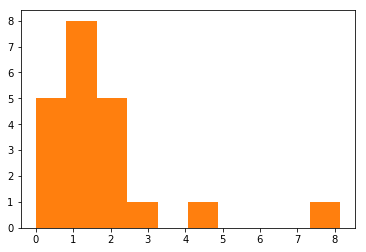

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


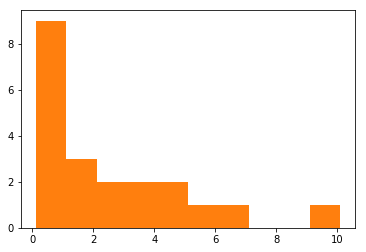

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


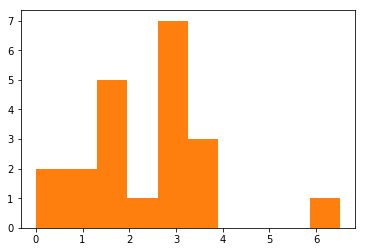

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


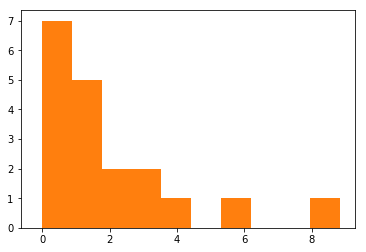

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


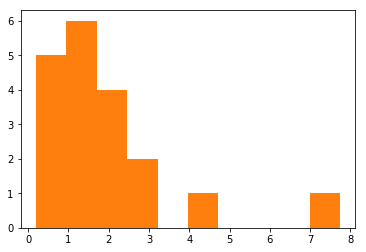

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) corr_coeff_similarity
array([1.40716894, 1.40716894, 1.40716894])


In [ ]:
sparsity = np.unique(uoien['sparsity'])
correlation = np.unique(uoien['cov_params'])
block_size = 6
s1 = sparsity.size
s2 = correlation.size
for i, s in enumerate(sparsity):
    for j, c in enumerate(correlation):
        # Find the indices of false positives:
        dd = d1.loc[(d1['cov_params'] == c) & (d1['sparsity'] == s)]
        fp_indices = []

        # Reproduce the covariance matrix
        sigma = block_covariance(60, block_size, c)
        
        # Remove the diagonal
        sigma = sigma - np.diag(np.diag(sigma))
        
        for k in range(15):
            beta_hats = dd.iloc[0].beta_hats[k, :].ravel()
            betas = dd.iloc[0].betas[k, :].ravel()
            fp_indices = np.nonzero(np.multiply(beta_hats, 1 * (betas ==  0)))[0]
            # Having identified the nonzero indices, compare the magnitudes
            # of the estimated coefficients with that of variables that are
            # highly correlated with the variables within the block

            # If there are no false positives, continue
            if fp_indices.size == 0:
                continue

            for idx in fp_indices:

                # Find indices of variables that are highly correlated
                betaself = beta_hats[idx]
                sigma_row = sigma[idx, :].copy()
                block_idxs = np.nonzero(sigma_row)[0]
                if block_idxs.size == 0:
                    continue 
                other_idxs = np.setdiff1d(np.arange(sigma_row.size), block_idxs)
                block_coeffs = np.array([beta_hats[x] for x in np.nonzero(beta_hats[block_idxs])[0]])

                # How similar are the correlated coefficients?
                corr_coeff_similarity = abs(betaself - block_coeffs)

                # How similar are the coefficients outside of the block
                rand_coeffs = np.array([beta_hats[x] for x in np.nonzero(beta_hats[other_idxs])[0]])
                rand_coeff_similarity = abs(betaself - rand_coeffs)
                fig, ax = plt.subplots()
                ax.hist(corr_coeff_similarity)
                ax.hist(rand_coeff_similarity)
                plt.show()
                if block_idxs.size != 0:
                    pdb.set_trace()

### Does Elastic Net exhibit the grouping effect?

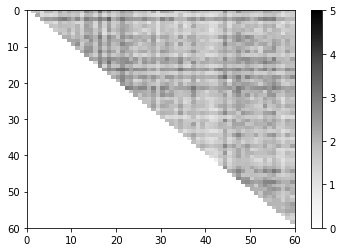

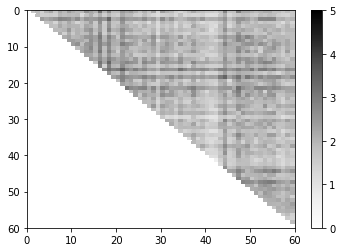

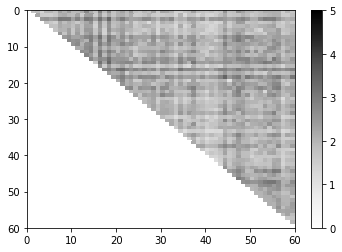

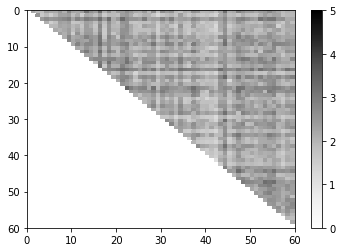

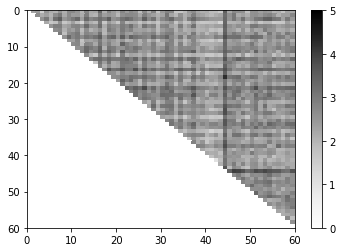

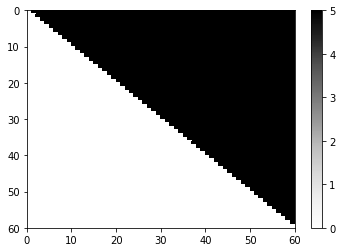

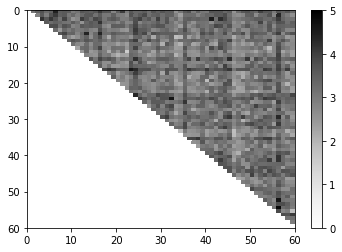

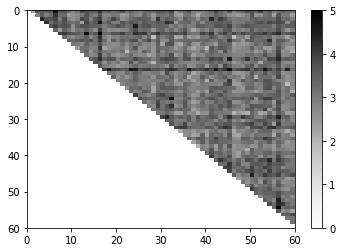

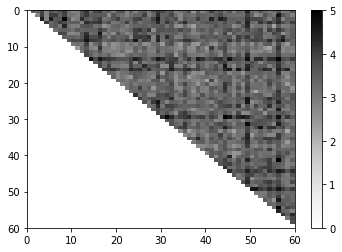

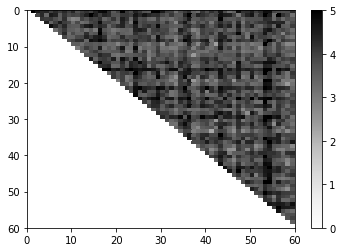

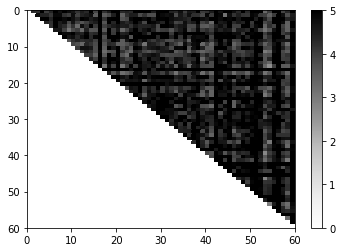

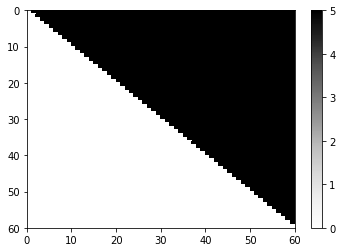

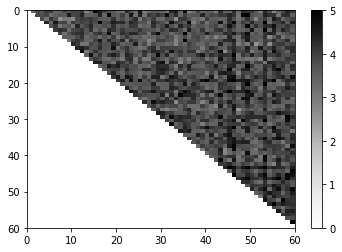

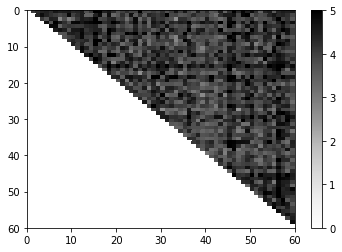

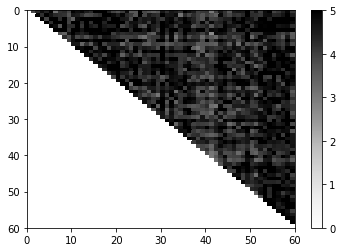

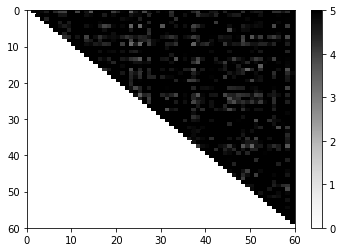

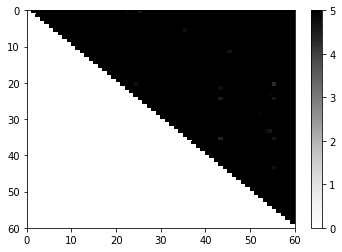

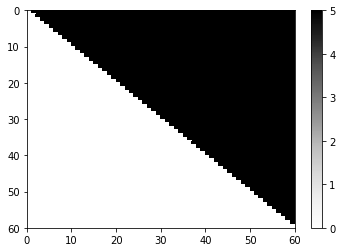

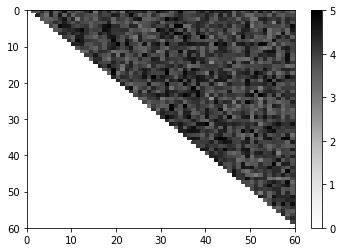

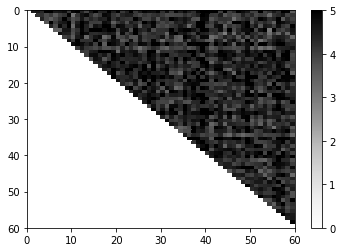

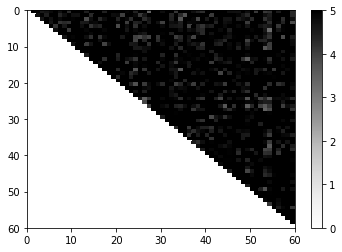

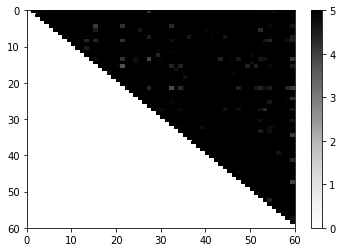

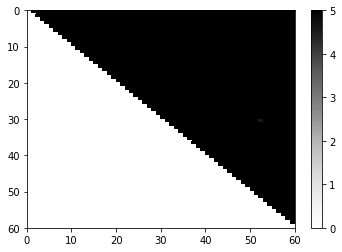

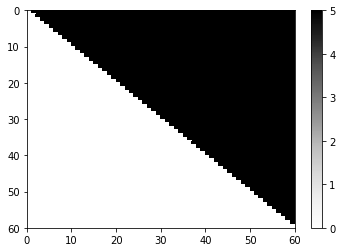

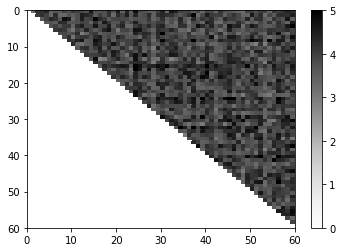

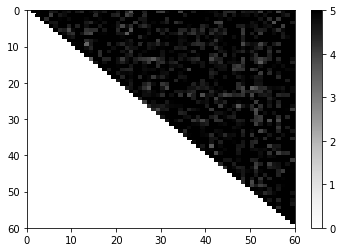

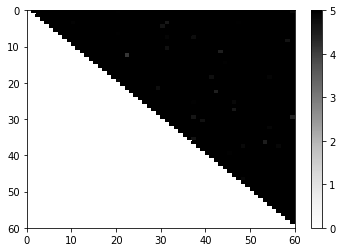

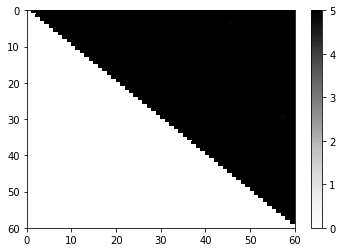

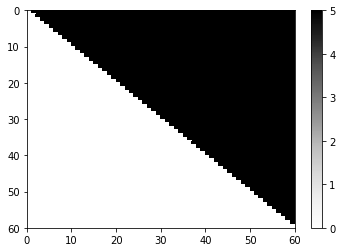

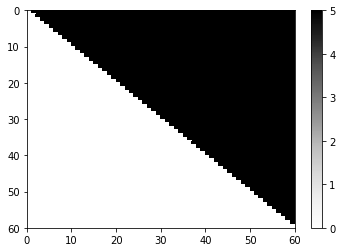

In [26]:
sparsity = np.unique(en['sparsity'])
correlation = np.unique(en['cov_params'])
block_size = 20
d1 = uoien.loc[en['block_size'] == block_size]
s1 = sparsity.size
s2 = correlation.size
for i, s in enumerate(sparsity):
    for j, c in enumerate(correlation):
 
        dd = d1.loc[(d1['cov_params'] == c) & (d1['sparsity'] == s)]
        coeff_sim = np.zeros((60, 60))
        for k in range(50):
            # For each coefficient, get pairwise similarity of coefficient magnitudes
            beta_hats = dd.iloc[0].beta_hats[k, :].ravel()
            for l1 in range(60):
                for l2 in range(l1, 60):
                    coeff_sim[l1, l2] += np.abs(beta_hats[l1] - beta_hats[l2])
            
        coeff_sim *= 1/50
        plt.pcolor(coeff_sim, vmin = 0, vmax = 5, cmap = 'Greys')
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()

In [32]:
np.arange(1, 11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Data is generated such that the group-wise sparsity is equal across groups. Given this, what is the distribution of false positives and false negatives across groups?

In [11]:
sparsity = np.unique(uoien['sparsity'])
correlation = np.unique(uoien['cov_params'])


block_size = 12
bins = np.array([0, 12, 24, 36, 48, 60])
s1 = sparsity.size
s2 = correlation.size

fp_membership1 = np.zeros((5, s1, s2, 50))
fn_membership1 = np.zeros((5, s1, s2, 50))

fp_membership2 = np.zeros((5, s1, s2, 50))
fn_membership2 = np.zeros((5, s1, s2, 50))

fp_membership3 = np.zeros((5, s1, s2, 50))
fn_membership3 = np.zeros((5, s1, s2, 50))

d1 = uoil.loc[uoil['block_size'] == block_size]
d2 = uoien.loc[uoien['block_size'] == block_size]
d3 = en.loc[en['block_size'] == block_size]

for i, s in enumerate(sparsity):
    for j, c in enumerate(correlation):
        dd1 = d1.loc[(d1['cov_params'] == c) & (d1['sparsity'] == s)]
        dd2 = d2.loc[(d2['cov_params'] == c) & (d2['sparsity'] == s)]
        dd3 = d3.loc[(d3['cov_params'] == c) & (d3['sparsity'] == s)]

        for rep in range(50):
            beta_hats = dd1.iloc[0].beta_hats[rep, :].ravel()
            betas = dd1.iloc[0].betas[rep, :].ravel()
            fp_indices = np.nonzero(np.multiply(beta_hats, 1 * (betas ==  0)))[0]
            fn_indices = np.nonzero(np.multiply(betas, 1 * (beta_hats == 0)))[0]

            assert(fp_indices.size == dd1.iloc[0].fp[rep])
            assert(fn_indices.size == dd1.iloc[0].fn[rep])
            
            # Assign group membership
            fp_members = np.digitize(fp_indices, bins, right=False)
            fn_members = np.digitize(fn_indices, bins, right=False)
            
            fp_membership1[:, i, j, rep] = np.array([np.count_nonzero(fp_members == x) for x in np.arange(1, 6)])
            fn_membership1[:, i, j, rep] = np.array([np.count_nonzero(fn_members == x) for x in np.arange(1, 6)])           
            
            beta_hats = dd2.iloc[0].beta_hats[rep, :].ravel()
            betas = dd2.iloc[0].betas[rep, :].ravel()
            fp_indices = np.nonzero(np.multiply(beta_hats, 1 * (betas ==  0)))[0]
            fn_indices = np.nonzero(np.multiply(betas, 1 * (beta_hats == 0)))[0]

            assert(fp_indices.size == dd2.iloc[0].fp[rep])
            assert(fn_indices.size == dd2.iloc[0].fn[rep])
            
            # Assign group membership
            fp_members = np.digitize(fp_indices, bins, right=False)
            fn_members = np.digitize(fn_indices, bins, right=False)
            
            fp_membership2[:, i, j, rep] = np.array([np.count_nonzero(fp_members == x) for x in np.arange(1, 6)])
            fn_membership2[:, i, j, rep] = np.array([np.count_nonzero(fn_members == x) for x in np.arange(1, 6)])           

            beta_hats = dd3.iloc[0].beta_hats[rep, :].ravel()
            betas = dd3.iloc[0].betas[rep, :].ravel()
            fp_indices = np.nonzero(np.multiply(beta_hats, 1 * (betas ==  0)))[0]
            fn_indices = np.nonzero(np.multiply(betas, 1 * (beta_hats == 0)))[0]

            assert(fp_indices.size == dd3.iloc[0].fp[rep])
            assert(fn_indices.size == dd3.iloc[0].fn[rep])

            # Assign group membership
            fp_members = np.digitize(fp_indices, bins, right=False)
            fn_members = np.digitize(fn_indices, bins, right=False)
            
            fp_membership3[:, i, j, rep] = np.array([np.count_nonzero(fp_members == x) for x in np.arange(1, 6)])
            fn_membership3[:, i, j, rep] = np.array([np.count_nonzero(fn_members == x) for x in np.arange(1, 6)])           

            

{'whiskers': [<matplotlib.lines.Line2D at 0x1ec58b63748>,
 'caps': [<matplotlib.lines.Line2D at 0x1ec58b63dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ec58b635f8>,
 'medians': [<matplotlib.lines.Line2D at 0x1ec58b6c4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ec58b6c7f0>,
 'means': []}

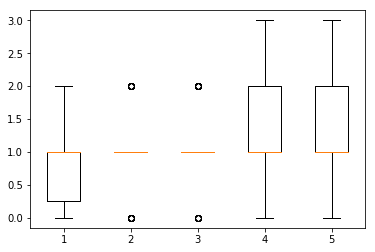

In [20]:
plt.boxplot(fp_membership1[:, 1, 5, :].T)